<a href="https://colab.research.google.com/github/chandini2595/Stanford_Hackathon_AI_ArgumentCounter/blob/main/Solution/Lawgorithms_StanfordHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bloomberg Hackathon: Brief Argument Counter-Argument Linking

## 📘 Overview
The goal is to link arguments from a moving brief to semantically matching counter-arguments from a response brief. This enables efficient legal research and drafting of rebuttals.

# 📂 Dataset Loading
Load and parse JSON format files containing paired arguments.

In [ ]:
import json
import zipfile
import os

# Upload and extract the zip
from google.colab import files
uploaded = files.upload()

with zipfile.ZipFile("stanford_hackathon_brief_pairs.zip", "r") as zip_ref:
    zip_ref.extractall("brief_data")

with open("brief_data/stanford_hackathon_brief_pairs.json", "r") as f:
    brief_pairs = json.load(f)

print(f"Total brief pairs: {len(brief_pairs)}")

Saving stanford_hackathon_brief_pairs.zip to stanford_hackathon_brief_pairs.zip
Total brief pairs: 10


## 📊 Exploratory Data Analysis (EDA)
We analyze the distribution of argument sections, sample texts, and heading patterns to understand the structure of briefs.


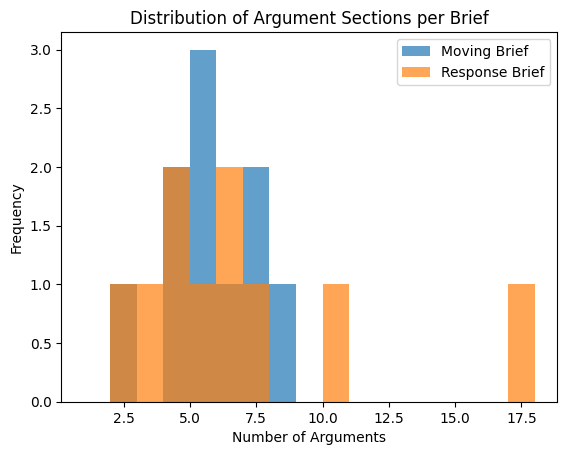

In [ ]:
import matplotlib.pyplot as plt

moving_counts = [len(pair["moving_brief"]["brief_arguments"]) for pair in brief_pairs]
response_counts = [len(pair["response_brief"]["brief_arguments"]) for pair in brief_pairs]

plt.hist(moving_counts, bins=range(1, max(moving_counts)+2), alpha=0.7, label='Moving Brief')
plt.hist(response_counts, bins=range(1, max(response_counts)+2), alpha=0.7, label='Response Brief')
plt.xlabel("Number of Arguments")
plt.ylabel("Frequency")
plt.title("Distribution of Argument Sections per Brief")
plt.legend()
plt.show()

In [ ]:
# Show example argument pair from a training brief
for pair in brief_pairs:
    if pair['split'] == 'train':
        m_arg = pair['moving_brief']['brief_arguments'][0]
        r_arg = pair['response_brief']['brief_arguments'][0]
        print("📘 Moving Argument Heading:", m_arg['heading'])
        print(m_arg['content'][:500], "...")

        print("\n📕 Response Argument Heading:", r_arg['heading'])
        print(r_arg['content'][:500], "...")
        break

📘 Moving Argument Heading: A. AN ARBITRATION AGREEMENT EXISTS AND MUST BE ENFORCED PER THE TERMS OF THE DEALERSHIP AGREEMENT.
As noted, the Dealership Agreement demonstrates a clear agreement to submit "any dispute," and "all disputes...concerning the subject matter" of the Dealership Agreement to "binding arbitration conducted in Atlanta, Georgia."  Exhibit A at § 18.  The language of the arbitration agreement is clear and unequivocal.
Plaintiff alleges that it is entitled to the rights and remedies under the Dealership Agreement and, indeed, all of the counts in its complaint are fundamentally predicated on the relat ...

📕 Response Argument Heading: Standard for Motions to Dismiss
In ruling on a motion to dismiss, the Court "must assume the truth of all well-plead facts and give the plaintiff the benefit of all reasonable inferences therefrom." Genzyme Corp. v. Fed. Ins. Co., 622 F.3d 62, 68 (1st Cir. 2010).  To survive a motion to dismiss, the non-moving party must allege "sufficie

## 🔧 TF-IDF Baseline Model
A classic baseline using cosine similarity on TF-IDF vectorized arguments.

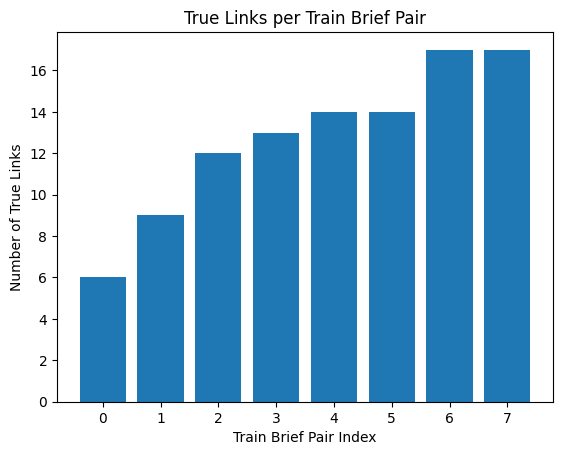

In [ ]:
link_counts = [len(pair['true_links']) for pair in brief_pairs if pair['split'] == 'train']

plt.bar(range(len(link_counts)), link_counts)
plt.xlabel("Train Brief Pair Index")
plt.ylabel("Number of True Links")
plt.title("True Links per Train Brief Pair")
plt.show()


In [ ]:
from collections import Counter

heading_counter = Counter()
for pair in brief_pairs:
    for arg in pair["moving_brief"]["brief_arguments"]:
        heading_counter[arg["heading"].strip()] += 1
    for arg in pair["response_brief"]["brief_arguments"]:
        heading_counter[arg["heading"].strip()] += 1

# Show top 10
heading_counter.most_common(10)

[('ARGUMENT', 5),
 ('BACKGROUND', 1),
 ('I. Likelihood of Success on the Merits', 1),
 ('II. Imminent Irreparable Harm', 1),
 ('III. Balance of the Harms', 1),
 ('IV. The Public Interest', 1),
 ('1. Plaintiffs Are Not Entitled to Injunctive Relief in an Inverse Condemnation Case.',
  1),
 ('2. Plaintiffs Are Not Likely to Succeed on Their State Claims', 1),
 ('B. PLAINTIFFS WILL NOT SUFFER IRREPARABLE HARM IN ABSENCE OF INJUNCTIVE RELIEF',
  1),
 ("C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR", 1)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine heading and content for better context
def combine_argument_text(arg):
    return arg["heading"] + ". " + arg["content"]

# Extract all texts from both moving and response briefs for global TF-IDF fit
all_texts = []
for pair in brief_pairs:
    for arg in pair["moving_brief"]["brief_arguments"]:
        all_texts.append(combine_argument_text(arg))
    for arg in pair["response_brief"]["brief_arguments"]:
        all_texts.append(combine_argument_text(arg))

# Fit TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
tfidf_vectorizer.fit(all_texts)


TfidfVectorizer(max_features=10000, stop_words='english')

In [ ]:
def predict_links_tfidf(pair, top_k=3):
    moving_args = pair["moving_brief"]["brief_arguments"]
    response_args = pair["response_brief"]["brief_arguments"]

    moving_texts = [combine_argument_text(arg) for arg in moving_args]
    response_texts = [combine_argument_text(arg) for arg in response_args]

    moving_vecs = tfidf_vectorizer.transform(moving_texts)
    response_vecs = tfidf_vectorizer.transform(response_texts)

    # Cosine similarity matrix
    sim_matrix = cosine_similarity(moving_vecs, response_vecs)

    # Top-K predictions for each moving argument
    predicted_links = []
    for i, m_arg in enumerate(moving_args):
        top_indices = sim_matrix[i].argsort()[::-1][:top_k]
        for j in top_indices:
            predicted_links.append((m_arg["heading"], response_args[j]["heading"]))

    return predicted_links


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Evaluate overlap between predicted and actual links
def evaluate_links(pred_links, true_links):
    pred_set = set(pred_links)
    true_set = set(tuple(t) for t in true_links)

    tp = len(pred_set & true_set)
    fp = len(pred_set - true_set)
    fn = len(true_set - pred_set)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return {"precision": precision, "recall": recall, "f1": f1}

# Run on all train pairs
train_results = []
for pair in brief_pairs:
    if pair["split"] == "train":
        pred = predict_links_tfidf(pair)
        true = pair["true_links"]
        metrics = evaluate_links(pred, true)
        train_results.append(metrics)

# Show average performance
pd.DataFrame(train_results).mean()


,0
precision,0.301389
recall,0.373079
f1,0.326137


In [ ]:
# Predict and print top-3 links for each moving argument on test set
test_pairs = [pair for pair in brief_pairs if pair["split"] == "test"]

for idx, pair in enumerate(test_pairs):
    print(f"\n🔹 Test Pair {idx + 1} — Moving Brief ID: {pair['moving_brief']['brief_id']}")
    pred_links = predict_links_tfidf(pair, top_k=3)
    for m, r in pred_links:
        print(f"📘 {m}  →  📕 {r}")



🔹 Test Pair 1 — Moving Brief ID: X1Q6O43B7MO2
📘 BACKGROUND  →  📕 2. Plaintiffs Are Not Likely to Succeed on Their State Claims
📘 BACKGROUND  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 BACKGROUND  →  📕 D. AN INJUNCTION IS NOT IN THE PUBLIC INTEREST
📘 I. Likelihood of Success on the Merits  →  📕 2. Plaintiffs Are Not Likely to Succeed on Their State Claims
📘 I. Likelihood of Success on the Merits  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 I. Likelihood of Success on the Merits  →  📕 E. THE INJUNCTIVE RELIEF THAT PLAINTIFFS SEEK VIOLATES RULE 65(d)(1)(C)
📘 II. Imminent Irreparable Harm  →  📕 2. Plaintiffs Are Not Likely to Succeed on Their State Claims
📘 II. Imminent Irreparable Harm  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 II. Imminent Irreparable Harm  →  📕 B. PLAINTIFFS WILL NOT SUFFER IRREPARABLE HARM IN ABSENCE OF INJUNCTIVE RELIEF
📘 III. Balance of the Harms  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 I

BERT-Based Matching Pipeline
Here’s a complete drop-in replacement for your TF-IDF pipeline using sentence-transformers.

## 🤖 Sentence-BERT Model
A semantic similarity model using `all-MiniLM-L6-v2` embeddings for more accurate linking of paraphrased or abstracted arguments.


In [ ]:
!pip install -U sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Use a compact, high-performing model
model = SentenceTransformer('all-MiniLM-L6-v2')
# Alternate for legal language: 'nlpaueb/legal-bert-base-uncased' (requires tokenizer/model loading separately)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Combine heading + content
def combine_argument_text(arg):
    return arg['heading'] + ". " + arg['content']

# Predict links using BERT embeddings and cosine similarity
def predict_links_bert(pair, top_k=3):
    moving_args = pair["moving_brief"]["brief_arguments"]
    response_args = pair["response_brief"]["brief_arguments"]

    moving_texts = [combine_argument_text(arg) for arg in moving_args]
    response_texts = [combine_argument_text(arg) for arg in response_args]

    # Encode using BERT
    moving_embeddings = model.encode(moving_texts, convert_to_tensor=True, show_progress_bar=False)
    response_embeddings = model.encode(response_texts, convert_to_tensor=True, show_progress_bar=False)

    # Compute cosine similarity
    cosine_scores = util.pytorch_cos_sim(moving_embeddings, response_embeddings)

    # Top-K for each moving argument
    predicted_links = []
    for i in range(len(moving_args)):
        top_indices = cosine_scores[i].argsort(descending=True)[:top_k]
        for j in top_indices:
            predicted_links.append((
                moving_args[i]["heading"],
                response_args[j]["heading"]
            ))

    return predicted_links


## 📈 Evaluation
We compute precision, recall, and F1-score using the train split with gold `true_links`.

In [ ]:
train_results_bert = []
for pair in brief_pairs:
    if pair["split"] == "train":
        pred = predict_links_bert(pair)
        true = pair["true_links"]
        metrics = evaluate_links(pred, true)
        train_results_bert.append(metrics)

import pandas as pd
pd.DataFrame(train_results_bert).mean()


,0
precision,0.324058
recall,0.388150
f1,0.346726


## 📦 Predictions on Test Set
Top-3 predicted counter-arguments per moving argument. Exported in `bert_predicted_links_test.json`.


In [ ]:
test_pairs = [pair for pair in brief_pairs if pair["split"] == "test"]

for idx, pair in enumerate(test_pairs):
    print(f"\n🔹 Test Pair {idx + 1} — Moving Brief ID: {pair['moving_brief']['brief_id']}")
    pred_links = predict_links_bert(pair, top_k=3)
    for m, r in pred_links:
        print(f"📘 {m}  →  📕 {r}")



🔹 Test Pair 1 — Moving Brief ID: X1Q6O43B7MO2
📘 BACKGROUND  →  📕 D. AN INJUNCTION IS NOT IN THE PUBLIC INTEREST
📘 BACKGROUND  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 BACKGROUND  →  📕 2. Plaintiffs Are Not Likely to Succeed on Their State Claims
📘 I. Likelihood of Success on the Merits  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 I. Likelihood of Success on the Merits  →  📕 2. Plaintiffs Are Not Likely to Succeed on Their State Claims
📘 I. Likelihood of Success on the Merits  →  📕 B. PLAINTIFFS WILL NOT SUFFER IRREPARABLE HARM IN ABSENCE OF INJUNCTIVE RELIEF
📘 II. Imminent Irreparable Harm  →  📕 B. PLAINTIFFS WILL NOT SUFFER IRREPARABLE HARM IN ABSENCE OF INJUNCTIVE RELIEF
📘 II. Imminent Irreparable Harm  →  📕 E. THE INJUNCTIVE RELIEF THAT PLAINTIFFS SEEK VIOLATES RULE 65(d)(1)(C)
📘 II. Imminent Irreparable Harm  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAINTIFFS' FAVOR
📘 III. Balance of the Harms  →  📕 C. THE BALANCE OF EQUITIES IS NOT IN PLAI

# 📁 Export BERT Test Predictions to JSON

In [ ]:
import json

bert_test_predictions = []
for pair in test_pairs:
    preds = predict_links_bert(pair, top_k=3)
    bert_test_predictions.append({
        "moving_brief_id": pair["moving_brief"]["brief_id"],
        "predicted_links": preds
    })

with open("bert_predicted_links_test.json", "w") as f:
    json.dump(bert_test_predictions, f, indent=2)

from google.colab import files
files.download("bert_predicted_links_test.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Load your predictions
with open("bert_predicted_links_test.json", "r") as f:
    predictions = json.load(f)

# Define a validator
def validate_prediction_schema(predictions):
    assert isinstance(predictions, list), "Top-level structure should be a list."

    for i, item in enumerate(predictions):
        assert isinstance(item, dict), f"Item {i} should be a dictionary."
        assert "moving_brief_id" in item, f"Missing 'moving_brief_id' in item {i}."
        assert "predicted_links" in item, f"Missing 'predicted_links' in item {i}."
        assert isinstance(item["predicted_links"], list), f"'predicted_links' in item {i} should be a list."

        for j, link in enumerate(item["predicted_links"]):
            assert isinstance(link, list) or isinstance(link, tuple), f"Link {j} in item {i} should be a list or tuple."
            assert len(link) == 2, f"Link {j} in item {i} should have exactly 2 elements (moving_heading, response_heading)."
            assert all(isinstance(h, str) for h in link), f"Each heading in link {j} of item {i} should be a string."

    print("✅ Schema is valid! Ready for submission.")

# Run the validator
validate_prediction_schema(predictions)


✅ Schema is valid! Ready for submission.


In [ ]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

## 📊 Cosine Similarity Heatmap
Visual inspection of model's semantic match scores across arguments.

In [ ]:
def plot_similarity_heatmap(pair, model, top_k=3):
    moving_args = pair["moving_brief"]["brief_arguments"]
    response_args = pair["response_brief"]["brief_arguments"]

    moving_texts = [combine_argument_text(arg) for arg in moving_args]
    response_texts = [combine_argument_text(arg) for arg in response_args]

    # Encode with BERT
    moving_emb = model.encode(moving_texts, convert_to_tensor=True)
    response_emb = model.encode(response_texts, convert_to_tensor=True)

    # Cosine similarity matrix
    cos_sim = util.pytorch_cos_sim(moving_emb, response_emb).cpu().numpy()

    # Prepare heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cos_sim,
        annot=True,
        fmt=".2f",
        xticklabels=[arg["heading"] for arg in response_args],
        yticklabels=[arg["heading"] for arg in moving_args],
        cmap="YlGnBu"
    )
    plt.title("Cosine Similarity Heatmap: Moving ↔ Response")
    plt.xlabel("Response Argument Headings")
    plt.ylabel("Moving Argument Headings")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


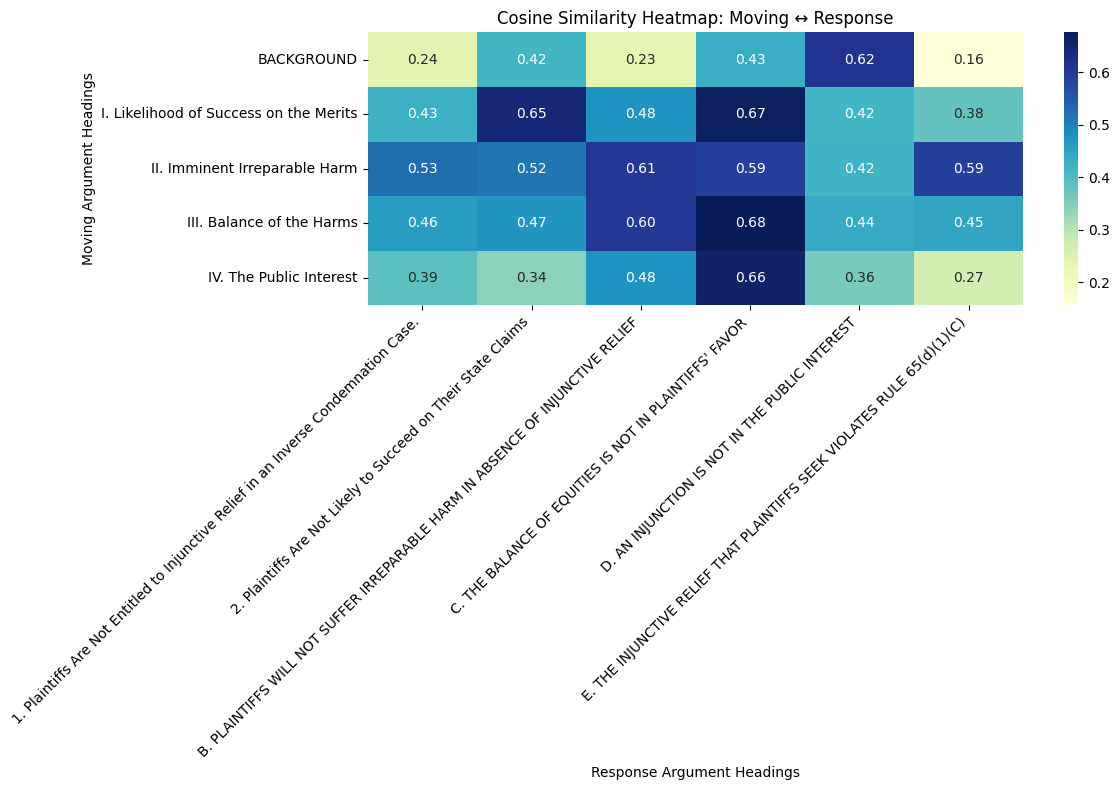

In [ ]:
# Show heatmap for first test pair
plot_similarity_heatmap(test_pairs[0], model)

In [ ]:
import numpy as np

def plot_annotated_similarity_heatmap(pair, model, top_k=3):
    import matplotlib.pyplot as plt
    import seaborn as sns

    moving_args = pair["moving_brief"]["brief_arguments"]
    response_args = pair["response_brief"]["brief_arguments"]

    moving_texts = [combine_argument_text(arg) for arg in moving_args]
    response_texts = [combine_argument_text(arg) for arg in response_args]

    # Encode using BERT
    moving_emb = model.encode(moving_texts, convert_to_tensor=True)
    response_emb = model.encode(response_texts, convert_to_tensor=True)

    # Compute cosine similarity matrix
    cos_sim = util.pytorch_cos_sim(moving_emb, response_emb).cpu().numpy()

    # Create a mask to mark top-k for each moving argument
    mask = np.full_like(cos_sim, False, dtype=bool)
    for i in range(cos_sim.shape[0]):
        top_indices = cos_sim[i].argsort()[-top_k:]
        mask[i, top_indices] = True

    # Format annotations: bold top-k matches
    annotations = np.empty_like(cos_sim, dtype=object)
    for i in range(cos_sim.shape[0]):
        for j in range(cos_sim.shape[1]):
            score = cos_sim[i, j]
            if mask[i, j]:
                annotations[i, j] = f"**{score:.2f}**"
            else:
                annotations[i, j] = f"{score:.2f}"

    # Plot heatmap
    plt.figure(figsize=(13, 9))
    sns.heatmap(
        cos_sim,
        annot=annotations,
        fmt="",
        xticklabels=[arg["heading"] for arg in response_args],
        yticklabels=[arg["heading"] for arg in moving_args],
        cmap="YlGnBu"
    )
    plt.title("📊 Cosine Similarity Heatmap with Top-K Matches Annotated")
    plt.xlabel("Response Argument Headings")
    plt.ylabel("Moving Argument Headings")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


<ipython-input-22-18e3a3b0db32>:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


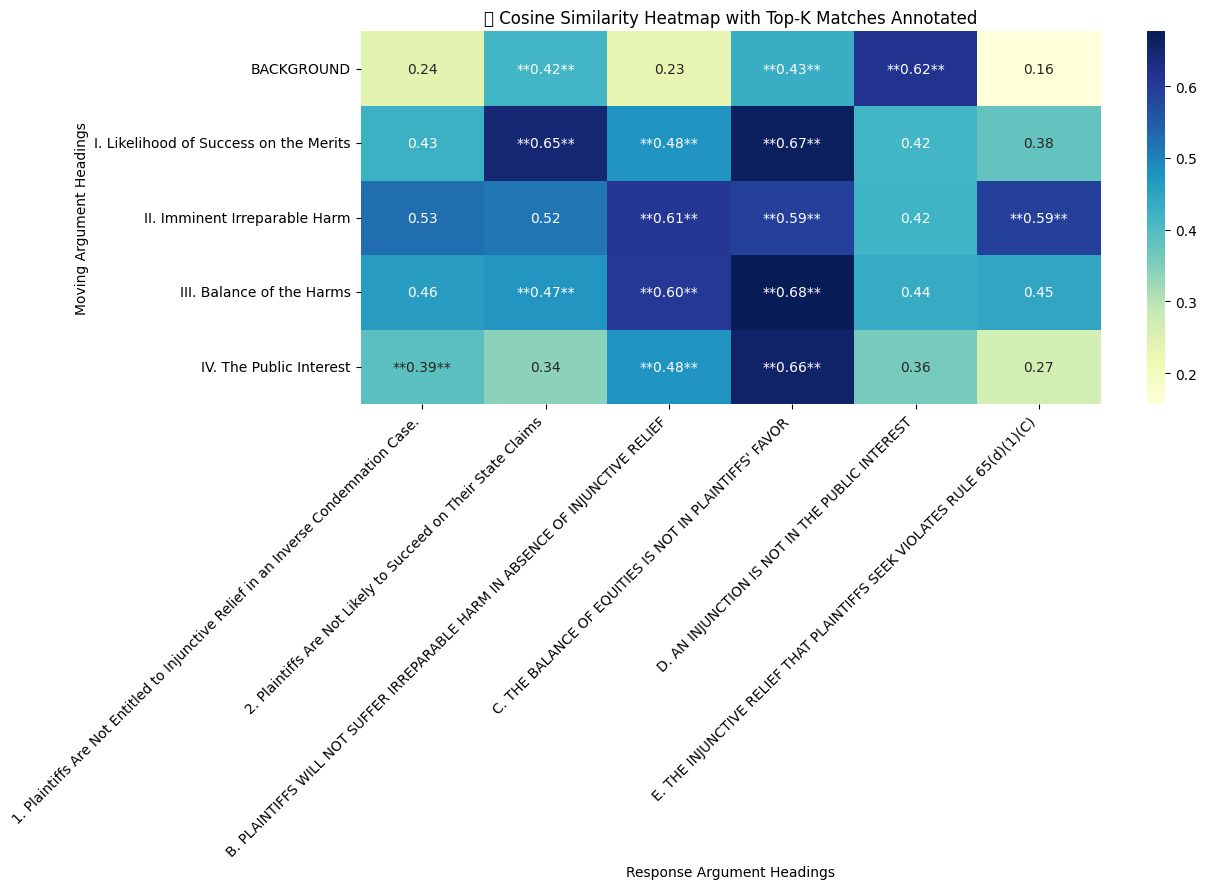

In [ ]:
plot_annotated_similarity_heatmap(test_pairs[0], model, top_k=3)


# UI

In [ ]:
!pip install gradio
import gradio as gr
import json
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("all-MiniLM-L6-v2")

brief_pairs = []
moving_brief_index = {}

def combine_argument_text(arg):
    return arg["heading"] + ". " + arg["content"]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
def handle_file_upload(file_obj):
    global brief_pairs, moving_brief_index
    brief_pairs = json.load(open(file_obj.name))

    moving_brief_index = {}
    for pair in brief_pairs:
        brief_id = pair["moving_brief"]["brief_id"]
        if brief_id not in moving_brief_index:
            moving_brief_index[brief_id] = {
                "pair": pair,
                "headings": [arg["heading"] for arg in pair["moving_brief"]["brief_arguments"]]
            }

    return gr.update(choices=list(moving_brief_index.keys()), value=None), gr.update(choices=[], value=None), []


In [ ]:
def get_headings_for_brief(brief_id):
    if brief_id not in moving_brief_index:
        return gr.update(choices=[], value=None)
    return gr.update(choices=moving_brief_index[brief_id]["headings"], value=None)


In [ ]:
def match_counter_arguments(brief_id, selected_heading, top_k=5):
    if brief_id not in moving_brief_index:
        return []

    pair = moving_brief_index[brief_id]["pair"]
    moving_args = pair["moving_brief"]["brief_arguments"]
    response_args = pair["response_brief"]["brief_arguments"]

    moving_index = next((i for i, arg in enumerate(moving_args) if arg["heading"] == selected_heading), None)
    if moving_index is None:
        return []

    moving_text = combine_argument_text(moving_args[moving_index])
    response_texts = [combine_argument_text(arg) for arg in response_args]

    moving_emb = model.encode([moving_text], convert_to_tensor=True)
    response_emb = model.encode(response_texts, convert_to_tensor=True)
    sim_scores = util.pytorch_cos_sim(moving_emb, response_emb)[0].cpu().numpy()

    top_indices = sim_scores.argsort()[::-1][:top_k]

    result_table = [["#", "Response Brief ID", "Heading", "Match %", "Excerpt"]]
    for i, idx in enumerate(top_indices):
        resp_arg = response_args[idx]
        excerpt = resp_arg["content"].replace("\n", " ").strip()[:300] + "..."
        result_table.append([
            str(i + 1),
            pair["response_brief"]["brief_id"],
            resp_arg["heading"],
            f"{sim_scores[idx] * 100:.2f}%",
            excerpt
        ])

    return result_table


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("## ⚖️ Upload & Match Legal Brief Arguments")

    file_upload = gr.File(label="📁 Upload `brief_pairs.json`")

    with gr.Row():
        dropdown_brief = gr.Dropdown(choices=[], label="📂 Select Moving Brief ID")
        dropdown_heading = gr.Dropdown(choices=[], label="📘 Select Argument Heading")

    output_table = gr.Dataframe(
        headers=["#", "Response Brief ID", "Heading", "Match %", "Excerpt"],
        row_count=6,
        col_count=5,
        wrap=True
    )

    # Step 1: Upload file → populate moving brief IDs
    file_upload.change(fn=handle_file_upload, inputs=file_upload,
                       outputs=[dropdown_brief, dropdown_heading, output_table])

    # Step 2: Select moving brief → get its headings
    dropdown_brief.change(fn=get_headings_for_brief, inputs=dropdown_brief, outputs=dropdown_heading)

    # Step 3: Select heading → predict matches
    dropdown_heading.change(fn=match_counter_arguments,
                            inputs=[dropdown_brief, dropdown_heading],
                            outputs=output_table)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee9e2b8f75741d9fa1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
